### 什么是卷积？
在数学中，卷积本质上是将两个函数混合成第三个函数。在图像处理的上下文中，卷积有点像以结构化的方式转换图像像素，同时考虑到附近的像素。在编码方面，让我们将图像视为具有3个通道（红色，绿色和蓝色）的二维像素阵列。我将抽象图像的颜色方面（仅用于灰度），但是本文的逻辑自然延伸到多通道2D图像。我们希望以结构化的方式转换数组的每个元素，同时考虑到附近的元素。

让我们看一看图像及其像素阵列。在这篇文章中，我将从Google图片下载狮子的灰度图片。我正在使用的狮子图像来自这里。

In [9]:
import numpy as np
from PIL import Image
from scipy import misc
from skimage import data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
from StringIO import StringIO
from __future__ import division

In [10]:
lion_arr = np.array(Image.open('./data/Lion.png'))

首先让我们看看狮子。

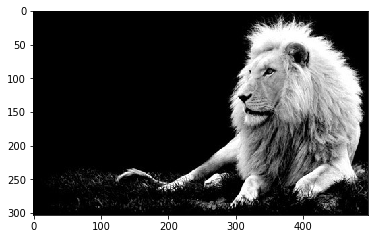

In [11]:
plt.imshow(lion_arr)

看起来不错。但是，尽管它看起来确实是灰度的，但该图像实际上仍然具有三个通道（红色，绿色和蓝色）。通过查看数组的形状可以看到这一点。也许所有颜色通道实际上都相同？

In [12]:
print lion_arr.shape
print np.array_equal(lion_arr[:, :, 0], lion_arr[:, :, 1])
print np.array_equal(lion_arr[:, :, 1], lion_arr[:, :, 2])

(303, 497, 3)
True
True


如果我们将这个3-D数组想象成3个单独的2-D数组，则每个2-D数组都是相同的。让我们只使用第一个通道作为图像。

In [13]:
lion_arr = lion_arr[:, :, 0]

让我们看一下图像数组。我们有0到255之间代表像素的数字行和列。

In [14]:
lion_arr[:200, :400]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  2,   2,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   1,   0, ...,   5,  86,  97],
       [  0,   1,   0, ...,  56, 114, 114],
       [  0,   1,   0, ..., 122, 130, 143]], dtype=uint8)

如果我们想对数组进行卷积，我们将以相同的方式遍历并转换每个元素。我们将定义一个二维kernel，然后将其应用于（乘以）数组中的每个元素。但是，我们实际上如何使用2-D内核？

### 与二维核的卷积
对于二维内核，我们需要将内核应用于形状与内核相同的图像补丁。因为我们仍然想从卷积中输出标量，所以我们将内核和补丁相乘，然后取结果输出数组的总和。

不过有一个问题。想象一下，依次将3 x 3色块移动通过5 x 5图像。您将从左上角开始，然后在图像上移动，直到点击右上角。那只需要三步。按照这种逻辑，我们最终得到的图像比开始时要小。为避免这种情况，我们在数组的两边都填充零。零允许我们将内核应用于每个像素。

更一般而言，要在apxq图像上传递mxm内核，我们需要在图像的两边填充m-2个零（其中m为奇数）。我们假设m为奇数，因此内核具有“中心”。

是时候做了。我将在狮子图像上卷积一个3 x 3的内核。首先，我将在每一行和每一列的末尾用零填充数组。然后，我将定义一个3 x 3内核，将其传递给填充图像中的每个3 x 3补丁，并对3 x 3内核和3 x 3数组进行元素逐个乘法。我将转换的总和存储在输出数组中，该数组的大小将与原始狮子数组的大小相同。

In [15]:
padded_array = np.pad(lion_arr, (1, 1), 'constant')
kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
output_array = np.zeros(lion_arr.shape)

for i in xrange(padded_array.shape[0]-2):
    for j in xrange(padded_array.shape[1]-2):
        temp_array = padded_array[i:i+3, j:j+3]
        output_array[i, j] = np.sum(temp_array*kernel)

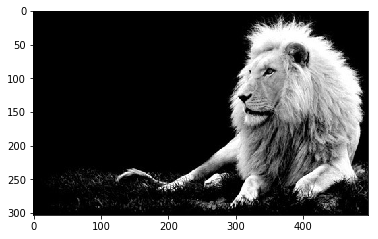

In [16]:
plt.imshow(output_array, cmap = plt.get_cmap('gray'))

一样的！为什么？由于内核，我们选择了对于图像中的任何给定色块，我们的卷积仅输出1*色块的中间元素。由于内核，所有其他元素到元素的乘法都变为0。因此，我们将此内核称为identity内核。

### 标准卷积
让我们看一下Wikipedia 页面上列出的示例内核。首先，我将定义一个将2D内核卷积在图像上的函数。由于我们正在计算总和，因此我们的输出值可以大于255或小于0。我们可能希望将这些值分别压缩为255和0，因此我将编写一个函数来实现此目的。有更好的方法来处理这种现象（例如，将输出值偏置一定量），但这目前仍然有效。

In [17]:
def squash_pixel_value(value):
    if value < 0:
        return 0
    elif value < 255:
        return value
    else:
        return 255

def conv_2d_kernel(image_array_2d, kernel, squash_pixels = True):
    padded_array = np.pad(image_array_2d, (1, 1), 'constant')
    
    kernel_width = kernel.shape[0]
    kernel_height = kernel.shape[1]
    
    transformed_array = np.zeros(image_array_2d.shape)
 
    for i in xrange(padded_array.shape[0] - kernel_width + 1):
        for j in xrange(padded_array.shape[1] - kernel_height + 1):
            temp_array = padded_array[i:i+kernel_width, j:j+kernel_height]
            #print temp_array.shape
            if squash_pixels:
                transformed_array[i, j] = squash_pixel_value(np.sum(temp_array*kernel))
            else:
                transformed_array[i, j] = np.sum(temp_array*kernel)
    return transformed_array

可以了，好了。我们准备在Wikipedia页面上进行每个转换。让我们看看结果如何。

#### 边缘检测

In [19]:
edge_kernel_1 = np.array([[1, 0, -1],
                          [0, 0, 0],
                          [-1, 0, 1]])

edge_kernel_2 = np.array([[0, 1, 0],
                          [1, -4, 1],
                          [0, 1, 0]])

edge_kernel_3 = np.array([[-1, -1, -1],
                          [-1, 8, -1],
                          [-1, -1, -1]])

lion_transf_edge1 = conv_2d_kernel(lion_arr, kernel = edge_kernel_1, squash_pixels = True)
lion_transf_edge2 = conv_2d_kernel(lion_arr, kernel = edge_kernel_2, squash_pixels = True)
lion_transf_edge3 = conv_2d_kernel(lion_arr, kernel = edge_kernel_3, squash_pixels = True)

(-0.5, 496.5, 302.5, -0.5)

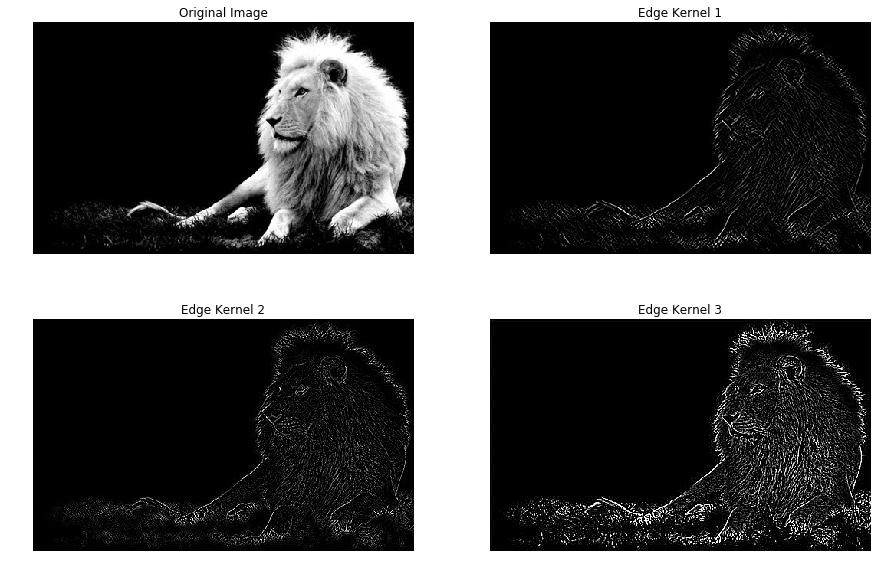

In [20]:
f, ax_array = plt.subplots(2, 2)
f.set_figheight(10)
f.set_figwidth(15)
ax_array[0, 0].imshow(lion_arr, cmap = plt.get_cmap('gray'))
ax_array[0, 0].set_title('Original Image')
ax_array[0, 0].axis('off')
ax_array[0, 1].imshow(lion_transf_edge1, cmap = plt.get_cmap('gray'))
ax_array[0, 1].set_title('Edge Kernel 1')
ax_array[0, 1].axis('off')
ax_array[1, 0].imshow(lion_transf_edge2, cmap = plt.get_cmap('gray'))
ax_array[1, 0].set_title('Edge Kernel 2')
ax_array[1, 0].axis('off')
ax_array[1, 1].imshow(lion_transf_edge3, cmap = plt.get_cmap('gray'))
ax_array[1, 1].set_title('Edge Kernel 3')
ax_array[1, 1].axis('off')

看起来每个边缘核都会使边缘依次变得更加鲜明。

#### 锐化

In [22]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

unsharp_kernel = np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, -476, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]]) / -256

lion_transf_sharpen = conv_2d_kernel(lion_arr, kernel = sharpen_kernel, squash_pixels = True)
lion_transf_unsharp = conv_2d_kernel(lion_arr, kernel = unsharp_kernel, squash_pixels = True)

(-0.5, 496.5, 302.5, -0.5)

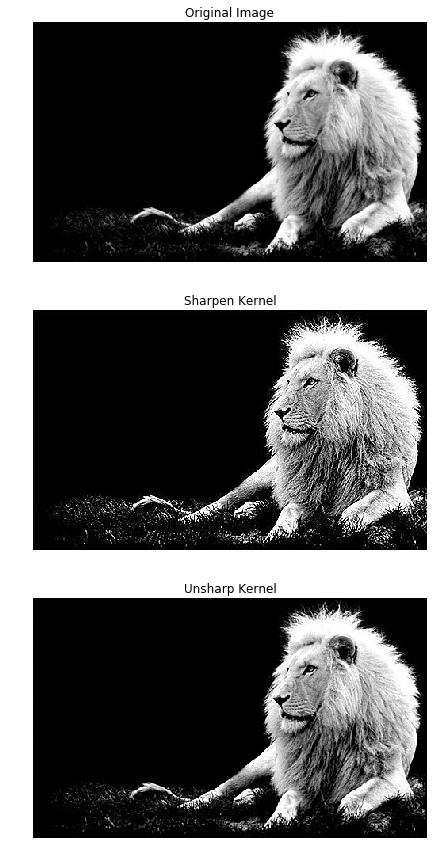

In [23]:
f, ax_array = plt.subplots(3, 1)
f.set_figheight(15)
f.set_figwidth(12)
ax_array[0].imshow(lion_arr, cmap = plt.get_cmap('gray'))
ax_array[0].set_title('Original Image')
ax_array[0].axis('off')
ax_array[1].imshow(lion_transf_sharpen, cmap = plt.get_cmap('gray'))
ax_array[1].set_title('Sharpen Kernel')
ax_array[1].axis('off')
ax_array[2].imshow(lion_transf_unsharp, cmap = plt.get_cmap('gray'))
ax_array[2].set_title('Unsharp Kernel')
ax_array[2].axis('off')

这些看起来也不错。与锐化内核的卷积清晰地使图像锐化，并且不锐利的内核看起来确实比原始图像稍微锐化（尽管不是很多）。

#### 模糊

In [24]:
blur_box_kernel = np.ones((3, 3)) / 9
blur_gaussian_kernel = np.array([[1,2,1],
                                 [2,4,2],
                                 [1,2,1]]) / 16

lion_transf_blur_box = conv_2d_kernel(lion_arr, kernel = blur_box_kernel, squash_pixels = True)
lion_transf_blur_gaussian = conv_2d_kernel(lion_arr, kernel = blur_gaussian_kernel, squash_pixels = True)

(-0.5, 496.5, 302.5, -0.5)

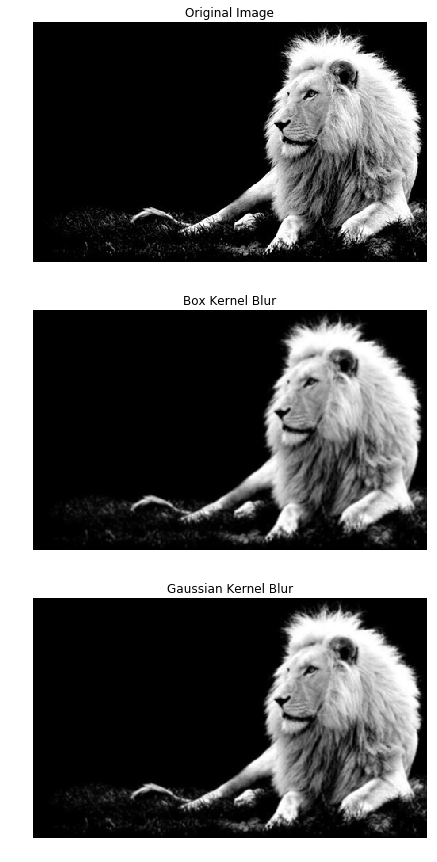

In [25]:
f, ax_array = plt.subplots(3, 1)
f.set_figheight(15)
f.set_figwidth(12)

ax_array[0].imshow(lion_arr, cmap = plt.get_cmap('gray'))
ax_array[0].set_title('Original Image')
ax_array[0].axis('off')
ax_array[1].imshow(lion_transf_blur_box, cmap = plt.get_cmap('gray'))
ax_array[1].set_title('Box Kernel Blur')
ax_array[1].axis('off')
ax_array[2].imshow(lion_transf_blur_gaussian, cmap = plt.get_cmap('gray'))
ax_array[2].set_title('Gaussian Kernel Blur')
ax_array[2].axis('off')

绝对模糊。